# Transfer learning and File-Tunining

- How to classify images of cats and dogs by using transfer learning from a pre-trained network

- Two ways to customer a pretained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simple add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that generically usefull for classifying pictures. However, the final classification part of pretrained model is specific to the original classfication task, and subsequently specific  to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

### Importing

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2025-04-02 20:22:58.256071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# glob.glob(f"{PATH}/cats_and_dogs_extracted/cats_and_dogs_filtered/*")

### Data preprocessing

#### Data Download

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), r"cats_and_dogs_extracted/cats_and_dogs_filtered/")

train_dir = os.path.join(PATH, "train")
validation_dr = os.path.join(PATH, "validation")

if not os.path.exists(train_dir) or not os.path.exists(validation_dr):
    raise FileNotFoundError("Unable to located dataset")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dr,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


The first nine images and labels from the training set:

2025-04-02 20:23:08.360492: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


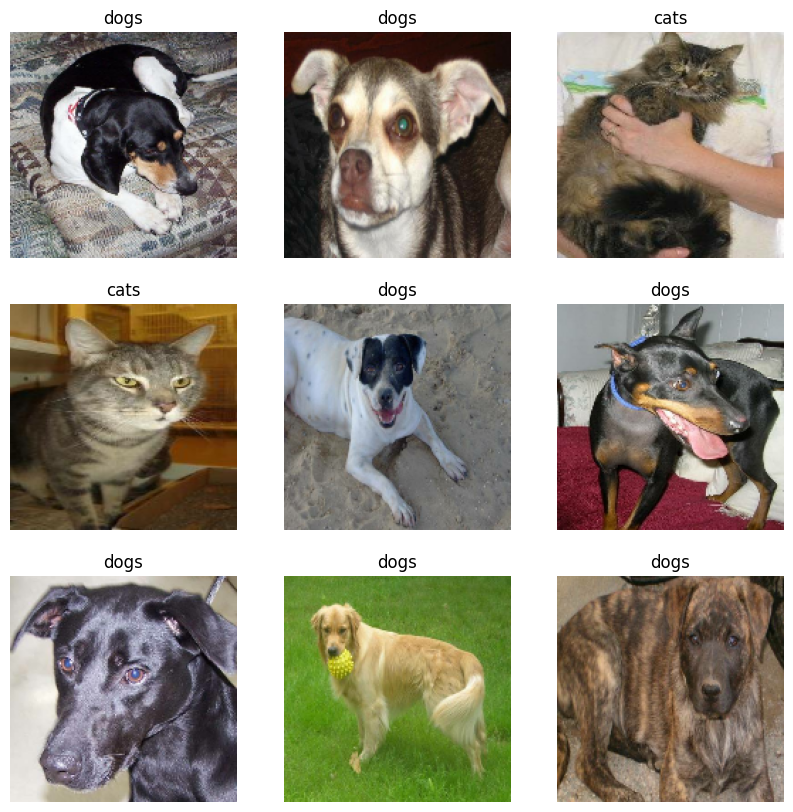

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The original dataset doesn't contain a test set, we'lll create one.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation

When you don't have a large image dataset, it's a good practice to articially introduce sample diversity by apply random, yet realistc, transformations to the training images, such as rotation and horizontal flip